In [63]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Data Preprocessing

Import waiter data csv file

In [2]:
waiter_data = pd.read_csv('./data/tips.csv')

In [3]:
waiter_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Check for null or missing values

In [4]:
waiter_data.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Get description of our dataset

In [5]:
waiter_data.info()
waiter_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


We have some nominal columns, such as sex, smoker, day, and time.
We can also see that the total_bill has a high standard deviation and will probably require some scaling.

Looking at the following we can see that more people visit the restaurant for dinner and during the weekend.

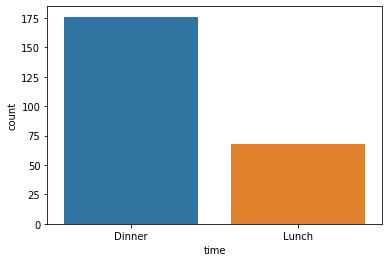

In [6]:
sns.countplot(waiter_data['time'])

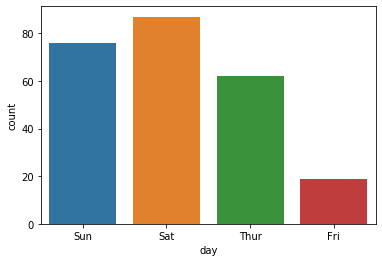

In [7]:
sns.countplot(waiter_data['day'])

Perform One-Hot encoding on the sex and smoker columns. 

Reason being LabelEncoding will assign numerical values to each new categorical value but the model could interpret the numerical values as having an ordering. 

We will use LabelEncoding on the day and time columns as there have an inherent ordering.

In [8]:
ohe = OneHotEncoder(sparse=False)

In [9]:
waiter_data['sex'] = ohe.fit_transform(waiter_data[['sex']])

In [10]:
waiter_data['smoker'] = ohe.fit_transform(waiter_data[['smoker']])

In [11]:
lenc = LabelEncoder()

In [12]:
waiter_data['day'] = lenc.fit_transform(waiter_data['day'])

In [13]:
waiter_data['time'] = lenc.fit_transform(waiter_data['time'])

In [14]:
waiter_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,1.0,1.0,2,0,2
1,10.34,1.66,0.0,1.0,2,0,3
2,21.01,3.50,0.0,1.0,2,0,3
3,23.68,3.31,0.0,1.0,2,0,2
4,24.59,3.61,1.0,1.0,2,0,4


So at this point we can split the data in training and testing data and apply scaling to the sets.

In [16]:
X = waiter_data.drop(['tip'], axis="columns")
y = waiter_data['tip']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that we have preprocessed all the categorical (both nominal and ordinal columns) we can proceed to apply scaling and normalization techniques to the data.

In [18]:
sc = StandardScaler()

In [19]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Models

Now we can create a couple of models and apply them to the scaled and pre-processed tipping data and compare their results.

In [27]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=10)))
models.append(('GradientBoost', GradientBoostingRegressor()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('SVR', SVR(gamma='scale')))

In [32]:
for name,model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=2)
    results = model_selection.cross_val_score(model, X_train, y_train, cv= kfold, scoring = 'neg_mean_absolute_error')
    msg  = "%s: %f" % (name, -1*(results).mean())
    print(msg)

LinearRegression: 0.801854
DecisionTree: 1.098103
RandomForest: 0.884785
GradientBoost: 0.831407
Ridge: 0.801805
Lasso: 1.050736
SVR: 0.781461


The lower the negative mean absolute error, the better the model is fitting the data.

## Linear Regression

In [98]:
lr = LinearRegression(normalize=True)

In [99]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [100]:
y_pred = lr.predict(X_test)

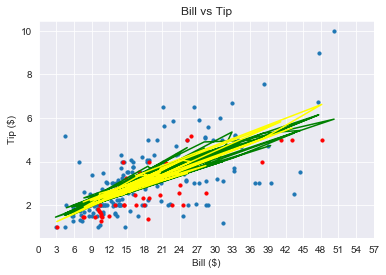

In [101]:
# Reverse Scaling
# Convert to dataframe
# get total_bill column and reshape for plotting
X_test_orig = sc.inverse_transform(X_test) #reverse scaling to plot 
X_df = pd.DataFrame(data=X_test_orig, columns=['total_bill', 'sex', 'smoker','day','time','size'])
X_df_bill = X_df['total_bill'].values.reshape(-1,1)

X_train_orig = sc.inverse_transform(X_train)
X_train_df = pd.DataFrame(data=X_train_orig, columns=['total_bill', 'sex', 'smoker', 'day', 'time','size'])
X_train_df_bill = X_train_df['total_bill'].values.reshape(-1,1)

# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_train_df_bill, y_train, s=10)
plt.plot(X_train_df_bill, lr.predict(X_train), color='green')
plt.scatter(X_df_bill, y_test, color='red', s=10)
plt.plot(X_df_bill, y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.xticks(np.arange(0, 60, 3))
plt.ylabel('Tip ($)')
plt.show()

Compare metrics

In [91]:
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred))) #RMSE
test_set_r2 = r2_score(y_test, y_pred) #R2

In [92]:
test_set_rmse

0.902959874916009

In [93]:
test_set_r2

0.3477158186131143

# Ridge Regression


In [109]:
ridge = Ridge(normalize=True)

In [110]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [111]:
ridge_y_pred = ridge.predict(X_test)

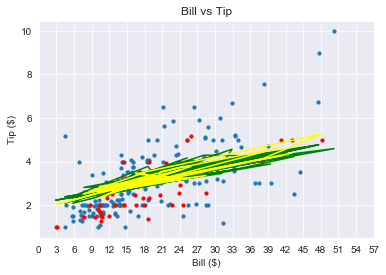

In [112]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_train_df_bill, y_train, s=10)
plt.plot(X_train_df_bill, ridge.predict(X_train), color='green')
plt.scatter(X_df_bill, y_test, color='red', s=10)
plt.plot(X_df_bill, ridge_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.xticks(np.arange(0, 60, 3))
plt.ylabel('Tip ($)')
plt.show()

In [113]:
ridge_rmse = (np.sqrt(mean_squared_error(y_test, y_pred))) #RMSE
ridge_r2 = r2_score(y_test, y_pred) #R2

In [114]:
ridge_rmse

0.902959874916009

In [115]:
ridge_r2

0.3477158186131143

# Lasso Regression

In [118]:
lasso = Lasso(normalize=True)

In [119]:
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [120]:
lasso_y_pred = lasso.predict(X_test)

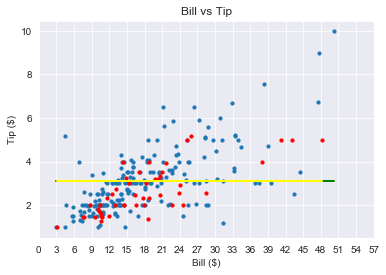

In [121]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_train_df_bill, y_train, s=10)
plt.plot(X_train_df_bill, lasso.predict(X_train), color='green')
plt.scatter(X_df_bill, y_test, color='red', s=10)
plt.plot(X_df_bill, lasso_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.xticks(np.arange(0, 60, 3))
plt.ylabel('Tip ($)')
plt.show()

In [ ]:
lasso_rmse = (np.sqrt(mean_squared_error(y_test, y_pred))) #RMSE
lasso_r2 = r2_score(y_test, y_pred) #R2

In [ ]:
lasso_rmse

# Decision Tree

In [122]:
decision = DecisionTreeRegressor(criterion='mae')

In [124]:
decision.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [127]:
decision_y_pred = decision.predict(X_test)

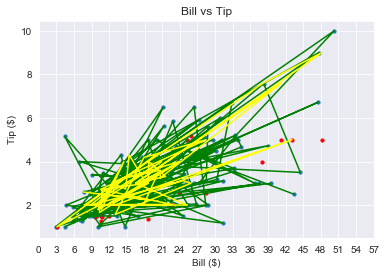

In [128]:
# Blue = Train; Red = Test
# Green = X_train + Predict(X_train)
# Yellow = X_test + y_pred
plt.scatter(X_train_df_bill, y_train, s=10)
plt.plot(X_train_df_bill, decision.predict(X_train), color='green')
plt.scatter(X_df_bill, y_test, color='red', s=10)
plt.plot(X_df_bill, decision_y_pred, color='yellow')
plt.title('Bill vs Tip')
plt.xlabel('Bill ($)')
plt.xticks(np.arange(0, 60, 3))
plt.ylabel('Tip ($)')
plt.show()

In [132]:
decision_rmse = (np.sqrt(mean_squared_error(y_test, y_pred))) #RMSE
decision_r2 = r2_score(y_test, y_pred) #R2

In [130]:
test_set_rmse

0.902959874916009

In [131]:
test_set_r2

0.3477158186131143